# Anamoly Detection Using Auto-Encoders

##### Note: This work is a implementation of autoencoders learnt and built using nvidia DLI institute data of KDD99 dataset. Data is not available but the implementation for any generic autoencoder detection remains the same.

In [8]:
# Import libraries that will be needed for the lab
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
import os, datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.cluster import KMeans

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.utils import plot_model
%load_ext tensorboard

import pickle

import random
random.seed(123)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import argparse
import pickle

data_path = './data'

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Load the Dataset

In [9]:
#Function for keeping the percentage of anomalous data
def reduce_anomalies(df, pct_anomalies=.01):
    labels = df['label'].copy()
    is_anomaly = labels != 'normal.'
    num_normal = np.sum(~is_anomaly)
    num_anomalies = int(pct_anomalies * num_normal)
    all_anomalies = labels[labels != 'normal.']
    anomalies_to_keep = np.random.choice(all_anomalies.index, size=num_anomalies, replace=False)
    anomalous_data = df.iloc[anomalies_to_keep].copy()
    normal_data = df[~is_anomaly].copy()
    new_df = pd.concat([normal_data, anomalous_data], axis=0)
    return new_df

In [11]:
#Pre Process the dataset

data_path = './data/kddcup.data.corrected'

col_names = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins","logged_in",
             "num_compromised","root_shell","su_attempted","num_root","num_file_creations","num_shells","num_access_files","num_outbound_cmds",
             "is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
             "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate","dst_host_diff_srv_rate",
             "dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate","dst_host_rerror_rate",
             "dst_host_srv_rerror_rate","label"]

df =  pd.read_csv(data_path, header=None, names=col_names, index_col=False)

le = LabelEncoder()
le.fit(df.label)

#Change the percentatge of anomalies from 0.01 to 0.05 
df = reduce_anomalies(df, pct_anomalies=0.01)

# capture the categorical variables and one-hot encode them
cat_vars = ['protocol_type', 'service', 'flag', 'land', 'logged_in','is_host_login', 'is_guest_login']

# find unique labels for each category
cat_data = pd.get_dummies(df[cat_vars])

numeric_vars = list(set(df.columns.values.tolist()) - set(cat_vars))
numeric_vars.remove('label')
numeric_data = df[numeric_vars].copy()

numeric_cat_data = pd.concat([numeric_data, cat_data], axis=1)

# capture the labels
labels = df['label'].copy()

# convert labels to integers
integer_labels = le.transform(labels)

# split data into test and train
x_train, x_test, y_train, y_test = train_test_split(numeric_cat_data,
                                                    integer_labels,
                                                    test_size=.25, 
                                                    random_state=42)

# save the datasets for later use
preprocessed_data = {
    'x_train':x_train,
    'y_train':y_train,
    'x_test':x_test,
    'y_test':y_test,
    'le':le
}

# pickle the preprocessed_data
path = 'preprocessed_data_full.pkl'
out = open(path, 'wb')
pickle.dump(preprocessed_data, out)
out.close()


In [12]:
filename = './preprocessed_data_full.pkl'
input_file = open(filename,'rb')
preprocessed_data = pickle.load(input_file)
input_file.close()

In [13]:
le = preprocessed_data['le']
x_train = preprocessed_data['x_train']
y_train = preprocessed_data['y_train']
x_test = preprocessed_data['x_test']
y_test = preprocessed_data['y_test']

# Data Preprocessing

In [14]:
# Normalize the testing and training data using the MinMaxScaler from the scikit learn package
scaler = MinMaxScaler()

# Make sure to only fit the scaler on the training data
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# convert the data to FP32
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

In [15]:
# Intialize the AutoEncoders

input_dim = x_train.shape[1]

# model hyperparameters
batch_size = 512

latent_dim = 4 

max_epochs = 10 

# The encoder will consist of a number of dense layers that decrease in size 
# as we taper down towards the bottleneck of the network, the latent space
input_data = Input(shape=(input_dim,), name='encoder_input')

# hidden layers
encoder = Dense(96,activation='tanh', name='encoder_1')(input_data)
encoder = Dropout(.1)(encoder)
encoder = Dense(64,activation='tanh', name='encoder_2')(encoder)
encoder = Dropout(.1)(encoder)
encoder = Dense(48,activation='tanh', name='encoder_3')(encoder)
encoder = Dropout(.1)(encoder)
encoder = Dense(16,activation='tanh', name='encoder_4')(encoder)
encoder = Dropout(.1)(encoder)

# bottleneck layer
latent_encoding = Dense(latent_dim, activation='linear', name='latent_encoding')(encoder)


encoder_model = Model(input_data, latent_encoding)

encoder_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 114)]             0         
                                                                 
 encoder_1 (Dense)           (None, 96)                11040     
                                                                 
 dropout (Dropout)           (None, 96)                0         
                                                                 
 encoder_2 (Dense)           (None, 64)                6208      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 encoder_3 (Dense)           (None, 48)                3120      
                                                                 
 dropout_2 (Dropout)         (None, 48)                0     

In [18]:
# Decoder network for reconstruction 

# The decoder network is a mirror image of the encoder network
decoder = Dense(16, activation='tanh', name='decoder_1')(latent_encoding)
decoder = Dropout(.1)(decoder)
decoder = Dense(48, activation='tanh', name='decoder_2')(decoder)
decoder = Dropout(.1)(decoder)
decoder = Dense(64, activation='tanh', name='decoder_3')(decoder)
decoder = Dropout(.1)(decoder)
decoder = Dense(96, activation='tanh', name='decoder_4')(decoder)
decoder = Dropout(.1)(decoder)

# The output is the same dimension as the input data we are reconstructing
reconstructed_data = Dense(input_dim, activation='linear', name='reconstructed_data')(decoder)

In [19]:
autoencoder_model = Model(input_data, reconstructed_data)

autoencoder_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 114)]             0         
                                                                 
 encoder_1 (Dense)           (None, 96)                11040     
                                                                 
 dropout (Dropout)           (None, 96)                0         
                                                                 
 encoder_2 (Dense)           (None, 64)                6208      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 encoder_3 (Dense)           (None, 48)                3120      
                                                                 
 dropout_2 (Dropout)         (None, 48)                0   

In [20]:
#Optimizers for auto-encoder model
opt = optimizers.Adam(learning_rate=.00001)

autoencoder_model.compile(optimizer=opt, loss='mse', metrics=['accuracy'])

In [21]:
#Train the model

tensorboard_callback = tf.keras.callbacks.TensorBoard('./logs',profile_batch=0,update_freq='epoch',histogram_freq=1)

train_history = autoencoder_model.fit(x_train, x_train,
        shuffle=True,
        epochs=max_epochs,
        batch_size=batch_size,
        validation_data=(x_test, x_test),
        callbacks=[tensorboard_callback])

Epoch 1/10
1440/1440 [==============================] - 22s 12ms/step - loss: 0.0422 - accuracy: 0.0463 - val_loss: 0.0164 - val_accuracy: 0.0897
Epoch 2/10
1440/1440 [==============================] - 15s 10ms/step - loss: 0.0227 - accuracy: 0.0681 - val_loss: 0.0118 - val_accuracy: 0.0550
Epoch 3/10
1440/1440 [==============================] - 15s 11ms/step - loss: 0.0167 - accuracy: 0.0778 - val_loss: 0.0095 - val_accuracy: 0.0341
Epoch 4/10
1440/1440 [==============================] - 15s 11ms/step - loss: 0.0128 - accuracy: 0.0799 - val_loss: 0.0071 - val_accuracy: 0.0584
Epoch 5/10
1440/1440 [==============================] - 15s 10ms/step - loss: 0.0104 - accuracy: 0.1036 - val_loss: 0.0061 - val_accuracy: 0.0153
Epoch 6/10
1440/1440 [==============================] - 15s 11ms/step - loss: 0.0091 - accuracy: 0.1349 - val_loss: 0.0054 - val_accuracy: 0.1742
Epoch 7/10
1440/1440 [==============================] - 16s 11ms/step - loss: 0.0082 - accuracy: 0.1513 - val_loss: 0.0052 -

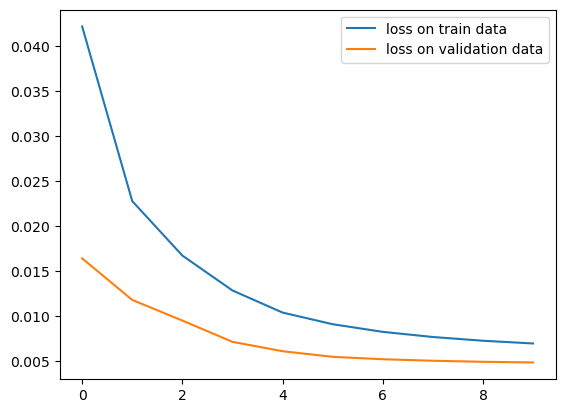

In [22]:
plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.legend(['loss on train data', 'loss on validation data'])

In [23]:
# Inspecting the training process

%tensorboard --logdir logs

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

# Anomaly detection

In [25]:
# We need to set reconstion error for test data , compute errors usine MSE and set threshold

# Reconstruct the data using our trainined autoencoder model.
x_test_recon = autoencoder_model.predict(x_test)

# the reconstruction score is the mean of the reconstruction errors (relatively high scores are anomalous)
reconstruction_scores = np.mean((x_test - x_test_recon)**2, axis=1)

7676/7676 [==============================] - 10s 1ms/step


In [26]:
# store the reconstruction data in a Pandas dataframe
anomaly_data = pd.DataFrame({'recon_score':reconstruction_scores})

# if our reconstruction scores our normally distributed we can use their statistics
anomaly_data.describe()

,recon_score
count,245627.000000
mean,0.004802
std,0.007880
min,0.000070
25%,0.001591
50%,0.001941
75%,0.004766
max,1.480508


<Axes: xlabel='Reconstruction Score', ylabel='Frequency'>

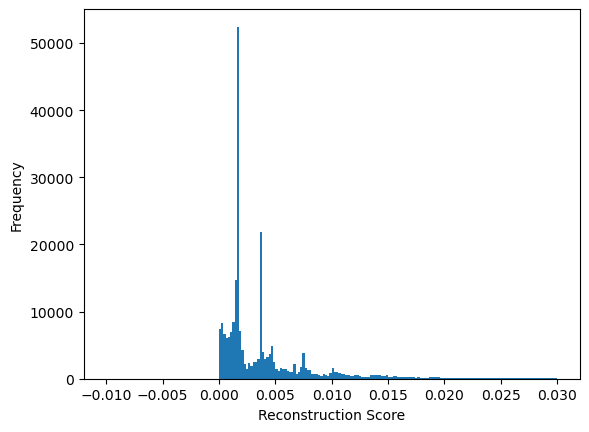

In [27]:
# plotting the density will give us an idea of how the reconstruction scores are distributed
plt.xlabel('Reconstruction Score')
anomaly_data['recon_score'].plot.hist(bins=200, range=[-.01, .03])

In [29]:
def convert_label_to_binary(label_encoder, labels):
    normal_idx = np.where(label_encoder.classes_ == 'normal.')[0][0]
    my_labels = labels.copy()
    my_labels[my_labels != normal_idx] = 1 
    my_labels[my_labels == normal_idx] = 0
    return my_labels

# Model Validation

In [30]:
# convert our labels to binary
binary_labels = convert_label_to_binary(le, y_test)

# add the binary labels to our anomaly dataframe
anomaly_data['binary_labels'] = binary_labels

# let's check if the reconstruction statistics are different for labeled anomalies
anomaly_data.groupby(by='binary_labels').describe()

recon_score                                                    \
                    count      mean       std       min       25%       50%   
binary_labels                                                                 
0                243161.0  0.004325  0.006186  0.000070  0.001589  0.001900   
1                  2466.0  0.051887  0.013212  0.001728  0.045932  0.045932   

                                   
                    75%       max  
binary_labels                      
0              0.004684  1.480508  
1              0.045932  0.083050

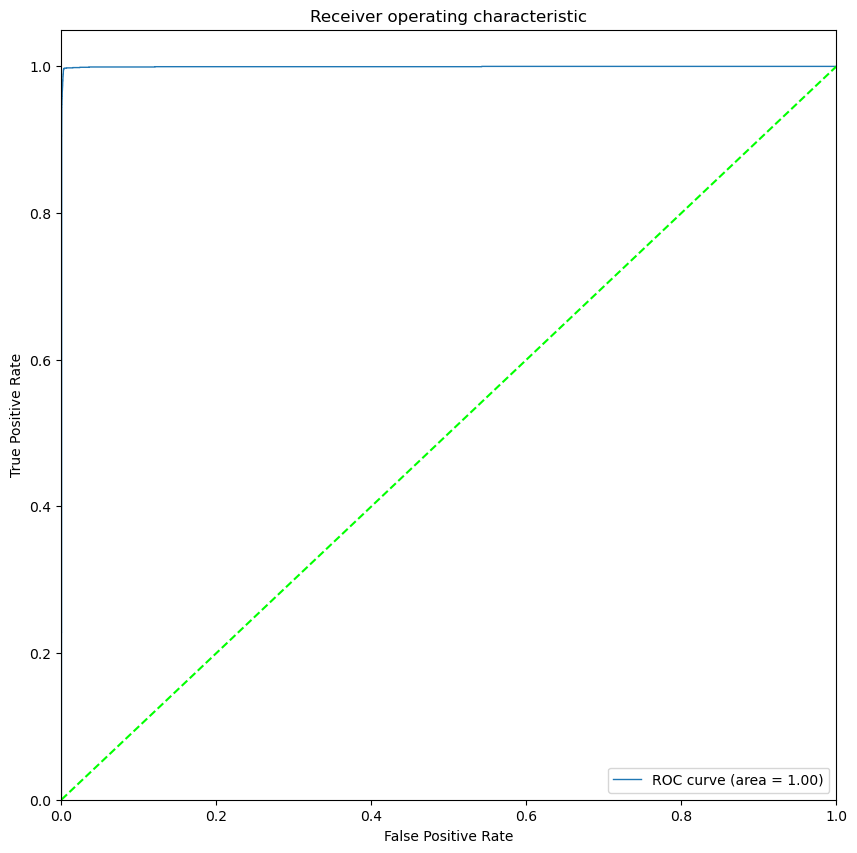

In [31]:
fpr, tpr, thresholds = roc_curve(binary_labels, reconstruction_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='lime', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [32]:
# We can pick the threshold based on maximizing the true positive rate (tpr) 
# and minimizing the false positive rate (fpr)
optimal_threshold_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_threshold_idx]
print(optimal_threshold)

0.031679943


In [33]:
# Or we assume our reconstructions are normally distributed and label anomalies as those
# that are a number of standard deviations away from the mean
recon_mean = np.mean(reconstruction_scores)
recon_stddev = np.std(reconstruction_scores)

stats_threshold = recon_mean + 5*recon_stddev
print(stats_threshold)

0.044210389256477356


In [34]:
# play around here and find the threshold that works for you

#thresh = optimal_threshold
thresh = stats_threshold

print(thresh)

pred_labels = (reconstruction_scores > thresh).astype(int)

results = confusion_matrix(binary_labels, pred_labels) 


0.044210389256477356
